#Prepared by: Mwaimu Ramadhan Ally
  

#Aim of the Project 

The aim of this assignment is to implement Image classification with convolutional neural network also ResNet Model and VGG16 Model 
To complity this task i have implmented VGG 16 and ResNet and our on model of CNN, and i try to commpare the differant mode and select the better one from them.

This study has been undertaken with the following objective. 

1.   Exploratory Data Analysis.
2.   To study about the problems in a given dataset to solve and to study and to state,what could be the source of issues during the training or inference phase, or what could be the source of ambiguity in the data.
3.   To do data pre-processing for the given problem
4.   To implement Hyper-parameter tuning.
5.   To do model selection (with given the best results for each tested model).
6.   Finale to do results section.












In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint


from keras.layers import Input, Dense, Conv2D, Dropout, BatchNormalization, Flatten
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Add, Multiply, Subtract, Activation, ZeroPadding2D
from keras.models import Sequential
#from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.models import Model
from keras.regularizers import l2


In [ ]:
def plot_history(history):
  # History for accuracy
  plt.figure(figsize=(14,5))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  # History for loss
  plt.subplot(1,2,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

In [ ]:
ds, ds_info = tfds.load("patch_camelyon", with_info=True)

In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

#**Data Preprocessing**
To keep the dataset size small Patch CAMELYON is stored as int8 patches. For network training we need float32 and we want to normalize between 0 and 1. The function below performs this task.

In [ ]:
def prepare_ds(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [ ]:
ds_train = ds['train']
ds_test = ds['test']
ds_val = ds['validation']


In [ ]:
ds_train = ds_train.map(prepare_ds,num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1024)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(2)


In [ ]:
ds_test = ds_test.map(prepare_ds,num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.repeat()
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(2)


In [ ]:
ds_val = ds_val.map(prepare_ds,num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.repeat()
ds_val = ds_val.batch(128)
ds_val = ds_val.prefetch(2)


#**Hyperparameter Tuning**

For the model, Kernel size was set to (3,3). Activation function used for the CNN model was 'relu' and also 'softmax'.
we also use momentum = 0.9 to control how much of the gradient from the previous step to keep in the current step.




#**CNN Model**

In [ ]:
#Input to the network 
input_img = Input(shape=(96,96,3))

# three blocks of two convolutional layers and a max-pool layer.
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(input_img)
x = Conv2D(16, (3, 3), padding='valid', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(32, (3, 3), padding='valid', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='valid', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

In [ ]:
model = Model(inputs=input_img, outputs=output)
opt = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 42, 42, 32)        9248      
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.save("CNNModel.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
hist = model.fit(ds_train, validation_data=ds_val, epochs=10, steps_per_epoch=4096, validation_steps=256)

Epoch 1/10
4096/4096 [==============================] - 231s 51ms/step - loss: 0.4896 - accuracy: 0.7593 - val_loss: 0.4753 - val_accuracy: 0.7815
Epoch 2/10
4096/4096 [==============================] - 194s 47ms/step - loss: 0.3658 - accuracy: 0.8413 - val_loss: 0.3534 - val_accuracy: 0.8431
Epoch 3/10
3560/4096 [=========================>....] - ETA: 24s - loss: 0.2825 - accuracy: 0.8850

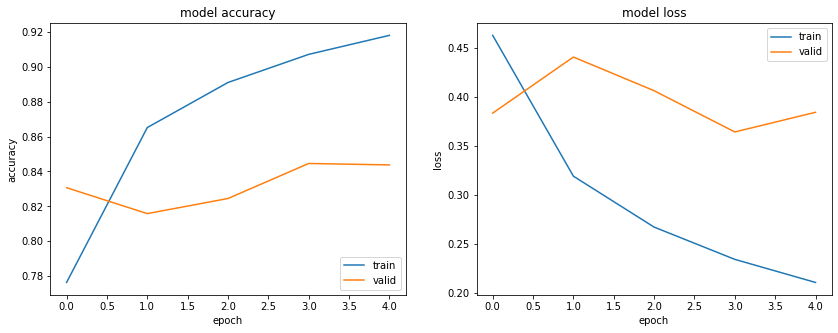

In [ ]:
plot_history(hist)

In [ ]:
model.evaluate(ds_test, return_dict=True, verbose=2,steps=256)

256/256 - 22s - loss: 0.3451 - accuracy: 0.8539 - 22s/epoch - 86ms/step


{'accuracy': 0.853912353515625, 'loss': 0.34510743618011475}

#**ResNet Model**

In [ ]:
def indentity_block(x_input, filters, activation='relu'):
  x = Conv2D(filters = filters, kernel_size = (1, 1), strides = (1,1), padding = 'same', kernel_regularizer=l2(1e-4))(x_input)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)

  x = Dropout(0.3)(x) 

  x = Conv2D(filters = filters, kernel_size = (3, 3), strides = (1,1), padding = 'same', kernel_regularizer=l2(1e-4))(x)
  x = BatchNormalization()(x)

  x = Add()([x, x_input])

  x = Activation(activation)(x)

  return x

def downsampling_identity_block(x_input, filters, activation='relu'):
  x = Conv2D(filters = filters, kernel_size = (1, 1), strides = (2,2), padding = 'same', kernel_regularizer=l2(1e-4))(x_input)
  x = BatchNormalization()(x)
  x = Activation(activation)(x)

  x = Dropout(0.3)(x) 

  x = Conv2D(filters = filters, kernel_size = (3, 3), strides = (1,1), padding = 'same', kernel_regularizer=l2(1e-4))(x)
  x = BatchNormalization()(x)

  x_skip = Conv2D(filters = filters, kernel_size = (1, 1), strides = (2,2), padding = 'same', kernel_regularizer=l2(1e-4))(x_input)
  x_skip = BatchNormalization()(x_skip)

  x = Add()([x, x_skip])

  x = Activation(activation)(x)

  return x

In [ ]:
def ResNet(input_shape = (96, 96, 3), classes = 2, activation='relu'):   
  # Define the input as a tensor with shape input_shape
  x_input = Input(input_shape)
  filters = 64
  # Zero-Padding
  x = ZeroPadding2D((3, 3))(x_input)
  
  # conv_1
 
  x = Conv2D(filters, (7,7), strides = (2, 2))(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = MaxPooling2D((7,7), strides=(2,2))(x)

  # conv_2_x
  x = indentity_block(x, filters, activation)
  x = indentity_block(x, filters, activation)

  # conv_3_x
  x = downsampling_identity_block(x, filters, activation)
  x = indentity_block(x, filters, activation)

  # conv_4_x
  x = downsampling_identity_block(x, filters, activation)
  x = indentity_block(x, filters, activation)

  # conv_5_x
  x = downsampling_identity_block(x, filters, activation)
  x = indentity_block(x, filters, activation)

  x = GlobalAveragePooling2D()(x)

  x = Dense(filters)(x)
  x = Dense(2)(x)
  output = Activation('softmax')(x)

  model = Model(inputs=x_input, outputs=output, name='ResNet18')

  return model

In [ ]:
model = ResNet((96, 96, 3), classes=2)
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.save("ResnetModel.h5")
print("Saved model to disk")

In [ ]:
model = ResNet((96, 96, 3), classes=2)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.save("ResnetModel.h5")
print("Saved model to disk")

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 102, 102, 3)  0          ['input_7[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_36 (Conv2D)             (None, 48, 48, 64)   9472        ['zero_padding2d_1[0][0]']       
                                                                                                  
 batch_normalization_20 (BatchN  (None, 48, 48, 64)  256         ['conv2d_36[0][0]']       

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Saved model to disk


In [ ]:
hist = model.fit(ds_train,
                 validation_data=ds_val, verbose = 2,epochs=20, steps_per_epoch=100, validation_steps=256)

Epoch 1/20
100/100 - 36s - loss: 0.7494 - accuracy: 0.6675 - val_loss: 0.7862 - val_accuracy: 0.4893 - 36s/epoch - 360ms/step
Epoch 2/20
100/100 - 29s - loss: 0.6345 - accuracy: 0.7522 - val_loss: 0.8097 - val_accuracy: 0.4308 - 29s/epoch - 292ms/step
Epoch 3/20
100/100 - 29s - loss: 0.6091 - accuracy: 0.7722 - val_loss: 0.9063 - val_accuracy: 0.6553 - 29s/epoch - 292ms/step
Epoch 4/20
100/100 - 29s - loss: 0.5967 - accuracy: 0.7736 - val_loss: 1.6280 - val_accuracy: 0.6440 - 29s/epoch - 294ms/step
Epoch 5/20
100/100 - 29s - loss: 0.5969 - accuracy: 0.7770 - val_loss: 1.5245 - val_accuracy: 0.6625 - 29s/epoch - 291ms/step
Epoch 6/20
100/100 - 29s - loss: 0.5596 - accuracy: 0.8000 - val_loss: 0.8309 - val_accuracy: 0.7198 - 29s/epoch - 294ms/step
Epoch 7/20
100/100 - 30s - loss: 0.5597 - accuracy: 0.8000 - val_loss: 0.8978 - val_accuracy: 0.7029 - 30s/epoch - 296ms/step
Epoch 8/20
100/100 - 29s - loss: 0.5710 - accuracy: 0.7923 - val_loss: 0.9146 - val_accuracy: 0.6693 - 29s/epoch - 292

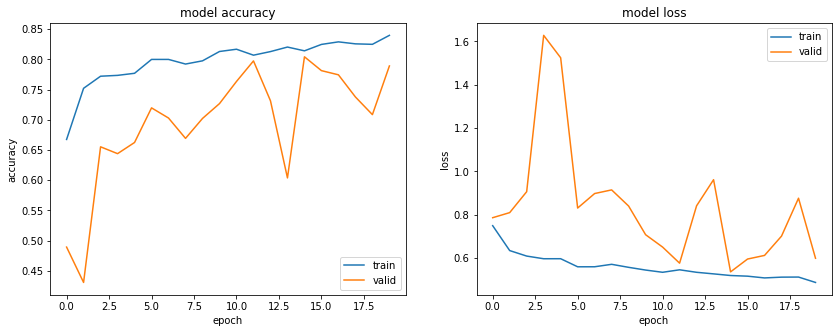

In [ ]:
plot_history(hist)

#**VGG16 Model**

In [ ]:
# input
 
input = Input(shape =(96,96,3))
# 1st Conv Block
 
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 2nd Conv Block
 
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 3rd Conv block
 
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# 4th Conv block
 
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
 
# 5th Conv block
 
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers
 
x = Flatten()(x)
x = Dense(units = 4096, activation ='relu')(x)
x = Dense(units = 4096, activation ='relu')(x)
output = Dense(units = 2, activation ='softmax')(x)
# creating the model
 
model = Model (inputs=input, outputs =output)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.save("VGGModel.h5")
print("Saved model to disk")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 96, 96, 64)        1792      
                                                                 
 conv2d_72 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 conv2d_74 (Conv2D)          (None, 48, 48, 128)       147584    
                                                           

In [ ]:
hist = model.fit(ds_train,
                 validation_data=ds_val, epochs=20, steps_per_epoch=100, validation_steps=256)

Epoch 1/20
100/100 [==============================] - 123s 1s/step - loss: 0.6923 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4995
Epoch 2/20
100/100 [==============================] - 103s 1s/step - loss: 0.6936 - accuracy: 0.5139 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 3/20
100/100 [==============================] - 103s 1s/step - loss: 0.6937 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.5005
Epoch 4/20
100/100 [==============================] - 103s 1s/step - loss: 0.6931 - accuracy: 0.4994 - val_loss: 0.6932 - val_accuracy: 0.4995
Epoch 5/20
100/100 [==============================] - 103s 1s/step - loss: 0.6940 - accuracy: 0.5064 - val_loss: 0.6941 - val_accuracy: 0.5005
Epoch 6/20
100/100 [==============================] - 103s 1s/step - loss: 0.6915 - accuracy: 0.5239 - val_loss: 0.6799 - val_accuracy: 0.6312
Epoch 7/20
100/100 [==============================] - 103s 1s/step - loss: 0.6038 - accuracy: 0.6659 - val_loss: 0.4731 - val_accuracy: 0.7716

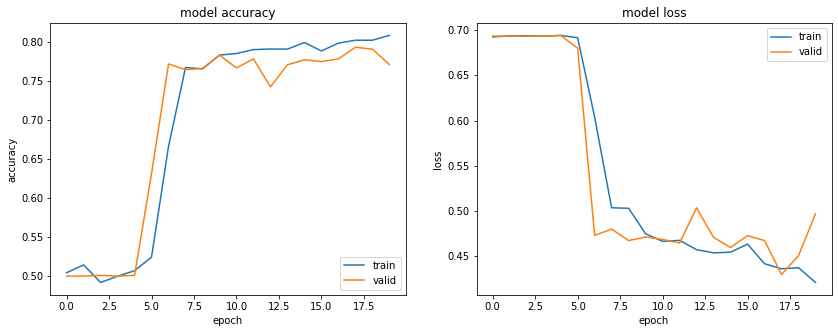

In [ ]:
plot_history(hist)

#**Conclusion**

Overall, i tried three different models and as the results suggest, the first model (Basic CNN) had the highest accuracy and would be an optimal choice for the Camelyon Classification Problem.

The major problem faced was the size of the dataset, and downloading it and processing was really time consuming, which is why for shuffling a smaller value of '1024' is used. 

